In [1]:
# installing the packages not available
!pip install pycocotools
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.3/403.3 kB 10.6 MB/s eta 0:00:0000:01


In [2]:
import torchvision
import torch
from torch.utils.data import Dataset
import numpy as np
import os
import pycocotools
import glob
from PIL import Image
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import albumentations as A
from torch.utils.data import DataLoader, Subset


In [3]:
class MaizeTasselDataset(Dataset):
    def __init__(self, directory, transforms, normalize=True):
        self.root = directory
        self.transforms = transforms
        self.normalize = normalize
        self.img_paths = sorted(glob.glob(os.path.join(self.root, "images", "*.jpg"), recursive=False))
        self.mask_paths = sorted(glob.glob(os.path.join(self.root, "masks", "*.jpg"), recursive=False))
        self.implicit_transform = torchvision.transforms.ToTensor()
        
    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])
        mask = np.array(mask)
        
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            ymin = np.min(pos[0])
            xmax = np.max(pos[1])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:,2] - boxes[:, 0])
        
        target = {}
        target["image_id"] = image_id
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["area"] = area
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.uint8)
        
        if self.transforms is not None:
            transformed = self.transforms(image=np.asarray(image),
                                          bboxes=boxes,
                                          bbox_labels=["pedestrian"]*num_objs,
                                          masks=list(np.asarray(target["masks"])))
            image = transformed["image"]
            target["boxes"] = torch.as_tensor(transformed["bboxes"], dtype=torch.float32)
            target["masks"] = torch.as_tensor(transformed["masks"], dtype=torch.uint8)
        
        if self.normalize:
            image = image / 255.
            
        
        return image, target
    
    def __len__(self):
        return len(self.img_paths)


torch.Size([3, 256, 256])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:207.)


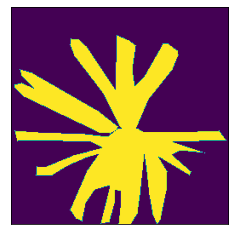

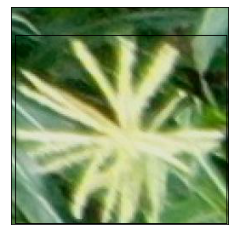

In [4]:
# visualize masks and the bounding boxes
# we use the albumentations for transforming the input images (noice library)
from albumentations.pytorch import ToTensorV2

def transformation(train=True):
    transform_list = []
    if train:
        transform_list.append(A.HorizontalFlip(p=0.5))
    transform_list.append(ToTensorV2())
    
    transforms = A.Compose(transform_list,
                           bbox_params=A.BboxParams(format="pascal_voc", label_fields=["bbox_labels"]))  # using only one augmentation of HorizontalFlip
    return transforms

root_dir = "/kaggle/input/tasselsegmentation"

def show(plots):
    if not isinstance(plots, list):
        plots = [plots]
    num_plots = len(plots)
    fig, axs = plt.subplots(ncols=num_plots, squeeze=False)
    for i, img in enumerate(plots):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticks=[], yticks=[])
    fig.show()
        
dataset = MaizeTasselDataset(root_dir, transformation(train=True), normalize=False)
image, target = next(iter(dataset))

print(image.shape)

result = draw_bounding_boxes(image, target["boxes"])  # using the inbuilt function for drawing the bounding boxes
maskimg = []  
for mask in target["masks"]:
    maskimg.append(mask)
show(maskimg)  # visualize the masks 
show(result)   # visualizethe bounding boxes.

In [5]:
# Using the pretrained Mask-RCNN model for the object detection and instance segmentation task
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

num_classes = 2  # the background class and the pedestrian class

def get_model(num_classes):
    pretrained_base_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # print(pretrained_base_model)

    in_features = pretrained_base_model.roi_heads.box_predictor.cls_score.in_features
    pretrained_base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    mask_in_channels = pretrained_base_model.roi_heads.mask_predictor.conv5_mask.in_channels
    pretrained_base_model.roi_heads.mask_predictor = MaskRCNNPredictor(mask_in_channels, 256, num_classes)
    return pretrained_base_model

In [6]:
# evaluation scripts
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
import copy

# we have to make the bboxes in the COCO data format i.e. [x, y, width, height]
# the current format that we use is that of the pascal_voc dataset [xmin, xmax, ymin, ymax]
# the pycocotools lib uses json format to process the evaluation results

def convert_to_xywh(boxes):
    w = boxes[:, 2] - boxes[:, 0]
    h = boxes[:, 3] - boxes[:, 1]
    boxes[:, 2], boxes[:, 3] = w, h
    return boxes

def convert_to_coco_api(images, annotations):
    needed_json = {"images":[], "annotations":[], "categories":[]}
    categories = set()
    ann_id = 1  # the annotation id starts from 1
    for img, ann in zip(images, annotations):
        image_id = ann["image_id"].item()
        image_dict = {}
        image_dict["id"] = image_id
        image_dict["height"] = img["height"]
        image_dict["width"] = img["width"]
        
        needed_json["images"].append(image_dict)
        
        boxes = ann["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        num_objs = len(boxes)
        for obj in range(num_objs):
            ann_dict = {}
            ann_dict["id"] = ann_id
            ann_dict["image_id"] = image_id
            ann_dict["category_id"] = ann["labels"][obj].item()
            categories.add(ann["labels"][obj].item())
            ann_dict["area"] = ann["area"][obj].item()
            ann_dict["bbox"] = boxes[obj]
            ann_dict["iscrowd"] = ann["iscrowd"][obj].item()
            ann_id += 1
            needed_json["annotations"].append(ann_dict)
        
    needed_json["categories"] = [{"id": id} for id in categories]
    return needed_json
        
        
    
def prepare_for_coco_detection(predictions):
    """
    predictions: {dict} ---> {image_id: prediction}
    Dict that maps each bbox prediction to its image_id.
    """
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

    
def evaluate(detections, ground_truths, images):
    """
    detections: {list} --> list of detections from each image.
    ground_truths: {list} --> list of ground_truth annotations for each image.
    images: {list} --> list of image_info includes the height and width of the image passed to the model for detection.
    """
    
    detections = {target["image_id"].item(): detection for target, detection in zip(ground_truths, detections)}
    ground_truths = convert_to_coco_api(images, ground_truths)
    detections = prepare_for_coco_detection(detections)

    with open('temp.json', "w") as fp:
        json.dump(detections, fp)
    with open("temp_gt.json", "w") as fp:
        json.dump(ground_truths, fp)
        
    coco_gts = pycocotools.coco.COCO("temp_gt.json")
    coco_dts = coco_gts.loadRes("temp.json")
    
    coco_eval = COCOeval(coco_gts, coco_dts, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    



In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
# the training script
import time

def main():
    root_dir = "/kaggle/input/tasselsegmentation"
    dataset = MaizeTasselDataset(root_dir, transformation(train=True), normalize=True)
    dataset_test = MaizeTasselDataset(root_dir, transformation(train=False), normalize=True)
    torch.random.manual_seed(1337)
    indices = torch.randperm(len(dataset), dtype=torch.uint8).tolist()
    
    dataset_train = Subset(dataset, indices[:-50])
    dataset_test = Subset(dataset_test, indices[-50:])
    
    trainloader = DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn)
    testloader = DataLoader(dataset_test, batch_size=2, shuffle=False, collate_fn=collate_fn)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    num_classes = 2
    model = get_model(num_classes)
    detections = []
    img_infos = []
    gts = []
    model.to(device)
    params = [p for p in model.parameters()]
    
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                  step_size=3,
                                                  gamma=0.1)
    
    num_epochs = 10
    for epoch in range(num_epochs):
        start = time.perf_counter()
        print("Epoch [{}]: ".format(epoch+1))
        
        model.train()
        
        # setting a warmup schedule for the first 1000 iterations 
        if epoch == 0:
            warmup_factor = 1.0 / 1000
            warmup_iters = min(1000, len(dataset_train) - 1)
            lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)
            
            
        for i, (images, targets) in enumerate(trainloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k,v in target.items()} for target in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            if lr_scheduler is not None:
                lr_scheduler.step()
            if i%10 == 0:
                print(["{}: {}".format(k, v) for k, v in loss_dict.items()])
        
        print("time taken {}".format(time.perf_counter() - start))
    
    torch.save(model, "model.pth")
    
    model.eval()
    with torch.no_grad():
        for i, (im, lb) in enumerate(testloader):
            print("testing..")
            images = list(im.to(device) for im in im)
            preds = model(images)
            print(".")
            detections.extend(preds)
            img_infos.extend([{"height": img.shape[2], "width": img.shape[1]} for img in images])
            gts.extend(list(lb for lb in lb))
            if (i+1) % 5 == 0:
                break

        evaluate(detections, gts, img_infos)


In [10]:
main() # trains the model for 10 epochs.

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Epoch [1]: 
['loss_classifier: 0.8252905607223511', 'loss_box_reg: 0.1057896763086319', 'loss_mask: 3.1475441455841064', 'loss_objectness: 0.0014099915279075503', 'loss_rpn_box_reg: 0.01660843938589096']
['loss_classifier: 0.14207805693149567', 'loss_box_reg: 0.1086621955037117', 'loss_mask: 0.9745950102806091', 'loss_objectness: 0.010359257459640503', 'loss_rpn_box_reg: 0.011516635306179523']
['loss_classifier: 0.06575677543878555', 'loss_box_reg: 0.08988583087921143', 'loss_mask: 0.5999305248260498', 'loss_objectness: 0.03237026929855347', 'loss_rpn_box_reg: 0.019964631646871567']
['loss_classifier: 0.03441420942544937', 'loss_box_reg: 0.06296832114458084', 'loss_mask: 0.510097086429596', 'loss_objectness: 0.011078504845499992', 'loss_rpn_box_reg: 0.010557746514678001']
['loss_classifier: 0.034233465790748596', 'loss_box_reg: 0.09496966004371643', 'loss_mask: 0.38246580958366394', 'loss_objectness: 0.013153070583939552', 'loss_rpn_box_reg: 0.009354972280561924']
['loss_classifier: 0.